<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_regularization_L2regu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

## Iris Dataset

In [28]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2


## Separating the data into DataLoaders

In [29]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# then convert them into pyTorch Datasets (note: already converted to tensor)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally trainslate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

## Cteate the model

In [30]:
class theModelClass(nn.Module):
    def __init__(self):
        super().__init__()

        ### layers
        self.input = nn.Linear(4, 64)
        self.hidden = nn.Linear(64, 64)
        self.output = nn.Linear(64, 3)

        # parameters
        # self.dr = dropoutRate

    # forward pass
    def forward(self, x):

        # pass the data through the input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        #x = F.dropout(x, p=self.dr, training=self.training) # training = self.training means to if is true then training mode otherwise eval mode

        # pass the data through the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        #x = F.dropout(x, p=self.dr, training=self.training) # training = self.training means to if is true then training mode otherwise eval mode

        # output layer
        x = self.output(x)

        # no dropout here!
        return x


In [31]:
# test the model
tmpnet = theModelClass()

# run some random data through
tmpdata = torch.randn((10, 4))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0955,  0.0835, -0.3323],
        [ 0.1803,  0.0132, -0.0252],
        [ 0.1997,  0.0574, -0.1239],
        [ 0.3097,  0.0523, -0.1812],
        [ 0.2748,  0.0231, -0.0996],
        [ 0.2655,  0.1498, -0.2881],
        [ 0.1272,  0.0182, -0.1848],
        [ 0.3116,  0.0584, -0.1483],
        [ 0.1938,  0.0548, -0.2659],
        [ 0.2527,  0.0791, -0.2442]], grad_fn=<AddmmBackward0>)

## Functions to create and train the net

In [32]:
def createANewModel(L2lambda):

    # grab an instance of the model class
    ANNQC = theModelClass()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr=0.005, weight_decay=L2lambda)

    return ANNQC, lossfun, optimizer

In [33]:
# train the model

# training parameters
numepochs = 1000

def trainTheModel(ANNQC, lossfun, optimizer):

    # initialize accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc = []
    losses = []

    # ANNQC.train()
    # switch training mode on (is this the right place for code ??): Nooooooooo

    # loop over epochs

    for epochi in range(numepochs):
        

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
            batchLoss.append(loss.item())

        # end of batch loop ...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # test accuracy
        ANNQC.eval() # switch training off
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        predlabels = torch.argmax(ANNQC(X), axis=1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

        # no worries, reset here :)
        ANNQC.train()


    # function output
    return trainAcc, testAcc, losses

## Test the model

In [34]:
# create a model
L2lambda = .01
ANNQC, lossfun, optimizer = createANewModel(L2lambda)

# train the model
trainAcc, testAcc, losses = trainTheModel(ANNQC, lossfun, optimizer)

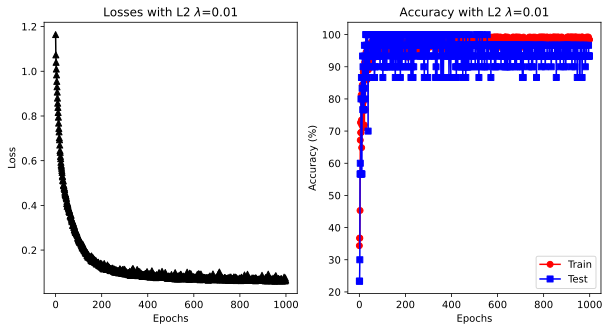

In [35]:
# plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(losses, 'k^-')
ax[0].set_title('Losses with L2 $\lambda$=' + str(L2lambda))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(trainAcc, 'ro-')
ax[1].plot(testAcc, 'bs-')
ax[1].set_title('Accuracy with L2 $\lambda$=' + str(L2lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train', 'Test'])

plt.show()

In [36]:
# create a 1D smoothing filter
def smooth(x, k=5):
    return np.convolve(x, np.ones(k) / k, mode='same')

## Now for the Experiments

In [37]:
# run an experiment 
l2lambdas = np.linspace(0, .1, 10)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# loop over batch sizes

for li in range(len(l2lambdas)):

    # create and train the model
    ANNQC, lossfun, optimizer = createANewModel(l2lambdas[li])
    trainAcc, testAcc, losses = trainTheModel(ANNQC, lossfun, optimizer)

    # store accuracies from last 100 epochs
    accuracyResultsTrain[:, li] = smooth(trainAcc)
    accuracyResultsTest[:, li] = smooth(testAcc)

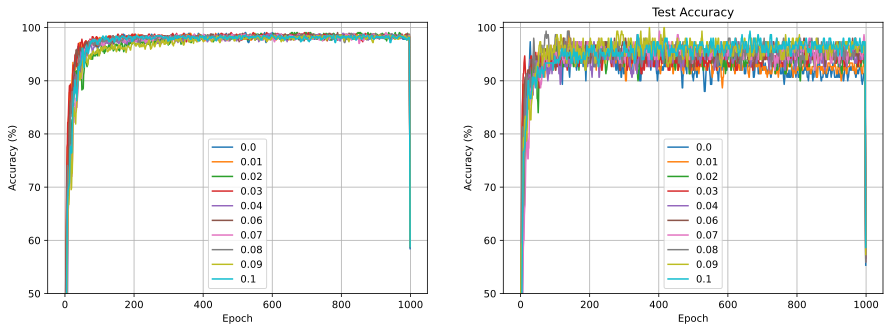

In [38]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(accuracyResultsTrain)
ax[0].set_xlabel('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test Accuracy')

# make the legend easier to read
leglabels = [np.round(i, 2) for i in l2lambdas]

# common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50, 101])
    ax[i].grid()


plt.show()

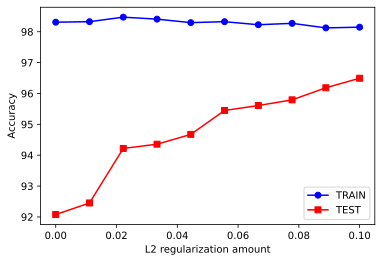

In [39]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500, 950]

plt.plot(l2lambdas,
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1], :], axis=0),
         'bo-', label='TRAIN')


plt.plot(l2lambdas,
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1], :], axis=0),
         'rs-', label='TEST')

plt.legend()
plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.show()